In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import tensorflow as tf

# Load in IMDB dataset
df = pd.read_csv('./data/imdb_labelled.txt', sep='\t+', header=None, names=['review', 'sentiment'], engine='python')

# Create a function to split data into train, validation, and test sets
def train_val_test_split(X, y, val_size=0.10, test_size=0.10, rand_seed=42):
    """
    Splits data into train, validation, and test sets.
    
    Args:
        X (pd.Series): Series of features
        y (pd.Series): Series of labels
        val_size (float): Proportion of data to use for validation set
        test_size (float): Proportion of data to use for test set
        rand_seed (int): Random seed for reproducibility
    
    Returns:
        Six pd.Series objects: X_train, X_val, X_test, y_train, y_val, y_test corresponding to
        the train, validation, and test sets for the features and labels respectively.
    """
    df = pd.DataFrame({X.name: X, y.name: y})
    
    val_int = int(val_size*len(df))
    test_int = int(test_size*len(df))
    
    train_split = len(df) - val_int - test_int
    val_split = len(df) - test_int
    
    shuf = df.sample(frac=1, random_state=rand_seed) # Shuffle rows
    
    X_train = shuf.iloc[:train_split][X.name]
    X_val = shuf.iloc[train_split:val_split][X.name]
    X_test = shuf.iloc[val_split:][X.name]
    y_train = shuf.iloc[:train_split][y.name]
    y_val = shuf.iloc[train_split:val_split][y.name]
    y_test = shuf.iloc[val_split:][y.name]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Split data into train, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df.review, df.sentiment)

# Use TextVectorization to create an input layer for the model that converts text to sequences of integers
vectorizer = tf.keras.layers.TextVectorization(max_tokens=5000, output_sequence_length=250)
vectorizer.adapt(X_train.values)


In [2]:
print(f'Vocab size : {vectorizer.vocabulary_size()}')
vocab = vectorizer.get_vocabulary()
print(f"Top 20 vocab items: {vocab[:20]}")
sample_text = ["This movie was fantastic!"]
sample_text_vectorized = vectorizer(sample_text)
print(f"Sample Text: {sample_text}")
print(f"Vectorized Text: {sample_text_vectorized}")
print(f"Tokens: {[vocab[word_index] for word_index in sample_text_vectorized[0][:20]]}")

Vocab size : 2720
Top 20 vocab items: ['', '[UNK]', 'the', 'and', 'a', 'of', 'is', 'this', 'i', 'it', 'to', 'in', 'was', 'movie', 'that', 'film', 'for', 'as', 'with', 'but']
Sample Text: ['This movie was fantastic!']
Vectorized Text: [[  7  13  12 532   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0 

In [3]:

# Build and compile the model
model = tf.keras.models.Sequential()
model.add(vectorizer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 16)                4016      
                                                                 
 dense_1 (Dense)             (None, 128)               2176      
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,273
Trainable params: 8,273
Non-trainable params: 0
______________________________________________________

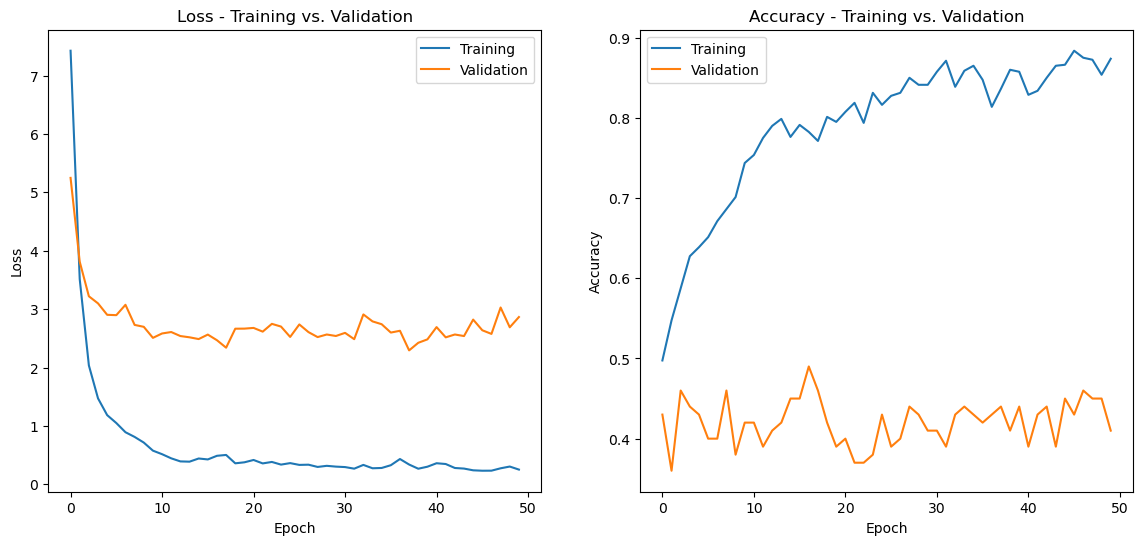

In [4]:
# Plot the learning curves for loss and accuracy on the same plot
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Loss - Training vs. Validation")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"])

    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Accuracy - Training vs. Validation")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training", "Validation"])
    plt.show()
    
plot_learning_curves(model.history)

In [5]:
# Try a different model architecture including an Embedding layer
# as well as using an LSTM layer

# Best model so far:
# model2 = tf.keras.Sequential()
# model2.add(vectorizer)
# model2.add(tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=10, mask_zero=True))
# model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.5)))
# model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, dropout=0.5)))
# model2.add(tf.keras.layers.Dense(16, activation='relu'))
# model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model2 = tf.keras.Sequential()
model2.add(vectorizer)
model2.add(tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=32, mask_zero=True))
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.5)))
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, dropout=0.5)))
model2.add(tf.keras.layers.Dense(10, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 32)           87040     
                                                                 
 bidirectional (Bidirectiona  (None, 250, 64)          16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 10)                330       
                                                      

In [6]:
# Train model this time adding an early stopping callback
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)])

Epoch 1/30
25/25 [==============================] - 13s 229ms/step - loss: 0.6928 - accuracy: 0.5213 - val_loss: 0.6916 - val_accuracy: 0.6000
Epoch 2/30
25/25 [==============================] - 3s 103ms/step - loss: 0.6820 - accuracy: 0.6888 - val_loss: 0.6791 - val_accuracy: 0.6100
Epoch 3/30
25/25 [==============================] - 3s 104ms/step - loss: 0.5415 - accuracy: 0.8100 - val_loss: 0.6271 - val_accuracy: 0.7500
Epoch 4/30
25/25 [==============================] - 3s 117ms/step - loss: 0.2747 - accuracy: 0.9212 - val_loss: 0.6652 - val_accuracy: 0.7600
Epoch 5/30
25/25 [==============================] - 2s 81ms/step - loss: 0.1637 - accuracy: 0.9475 - val_loss: 0.6976 - val_accuracy: 0.7600
Epoch 6/30
25/25 [==============================] - 2s 83ms/step - loss: 0.1226 - accuracy: 0.9775 - val_loss: 0.9452 - val_accuracy: 0.7200
Epoch 7/30
25/25 [==============================] - 2s 69ms/step - loss: 0.0900 - accuracy: 0.9787 - val_loss: 0.8277 - val_accuracy: 0.7900
Epoch 8/

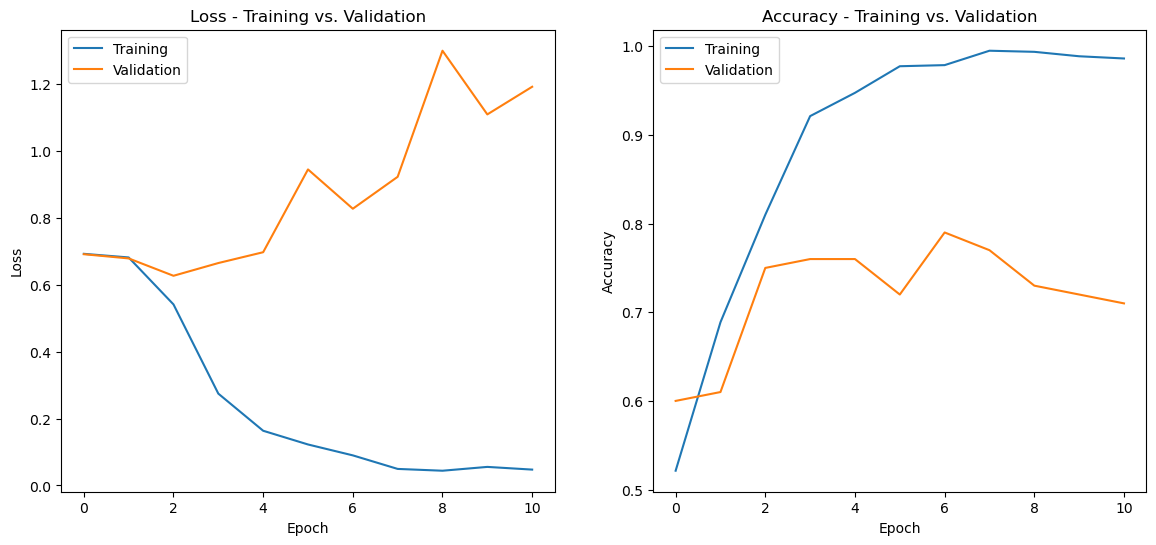

In [7]:
# Plot second model's learning curves
plot_learning_curves(model2.history)

In [8]:
model2.evaluate(X_test, y_test)

4/4 [==============================] - 0s 17ms/step - loss: 0.8003 - accuracy: 0.8000


[0.800325334072113, 0.800000011920929]

4/4 [==============================] - 2s 32ms/step


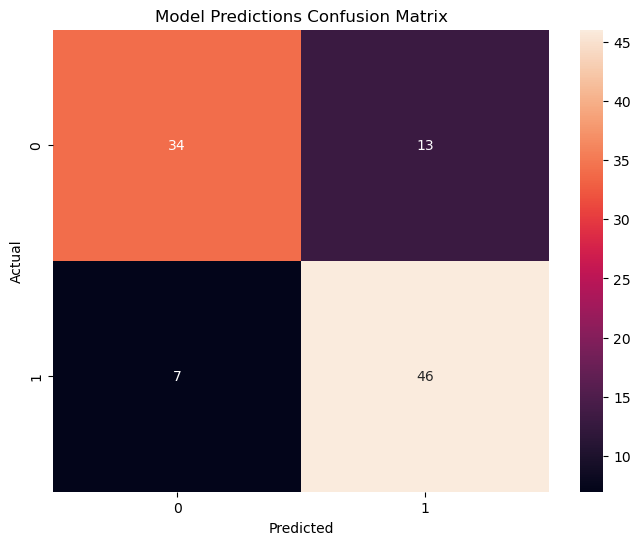

In [9]:
# Create a confusion matrix using numpy and pandas
# Plot confusion matrix with Seaborn heatmap
import numpy as np
import pandas as pd
import seaborn as sns

y_pred = model2.predict(X_test.values)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = y_pred.reshape(1, -1)[0]

def confusion_matrix(y_true, y_pred):
    data = {'y_Actual': y_true, 'y_Predicted': y_pred}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    return confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    cmatrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cmatrix, annot=True)
    plt.title('Model Predictions Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
plot_confusion_matrix(y_test, y_pred)

In [10]:
# Finally, try a pre-trained model from TensorFlow Hub and see how it performs
import tensorflow_hub as hub

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1', trainable=True)

outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(1, activation='sigmoid')(net)
model3 = tf.keras.Model(text_input, net)
model3.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

model3.summary()

FileNotFoundError: Op type not registered 'CaseFoldUTF8' in binary running on DESKTOP-O214IES. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [ ]:
classifier_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

In [ ]:
classifier_model.evaluate(X_test, y_test)

In [ ]:
y_pred = classifier_model.predict(X_test.values)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = y_pred.reshape(1, -1)[0]

plot_confusion_matrix(y_test, y_pred)